<img src="imgs/IISc_Master_Seal_Black_Transparent.png" height="120px" width="120px" align="right" />

<img src="imgs/logoGESS.jpg" height="120px" width="120px" align="right" />

<font face="Calibri">
<font size="7"> <b> PySHBundle Tutorials </b> </font>
<br> 
<font size="5"> <b> Tutorial 3: Visualizations with PySHBundle<font color='rgba(200,0,0,0.2)'>  </font> </b> </font>
<br> <br>
    
<font size="3"> <b> by: Abhishek Mhamane, IIT Kanpur</b> 
<font size="2">  <br>
<font> <b>Date: </b> August 27, 2023 </font>
</font>


In [1]:
from tqdm import trange
from datetime import datetime
import numpy as np
import cartopy
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import xarray as xr
import pyshbundle
from collections import OrderedDict

Initializing PySHbundle v0.3.0


In [2]:
from pyshbundle.pysh_core import gshs
from pyshbundle.shutils import plm, normalklm
from pyshbundle.reshape_SH_coefficients import clm2sc, clm2cs, sc2cs, cs2sc, klm2sc

In [3]:
from pyshbundle.io import extract_SH_data, extract_deg1_coeff_tn13, extract_deg2_3_coeff_tn14
from pyshbundle.io import extract_C10_11_replcmnt_coeff
from pyshbundle.io import extract_C20_replcmnt_coeff, extract_C30_replcmnt_coeff, find_date_in_replacemnt_file

In [5]:
##### depreciated and will be removed
# from pyshbundle.reshape_SH_coefficients import replace_zonal_coeff

In [6]:
from pyshbundle.shutils import Gaussian

In [7]:
from pyshbundle.viz_utils import sc_triplot, cs_sqplot, ylm, ylm_plot, mapfield, polar_plot, gshs_prepare

## Load Data

In [8]:
source='itsg'
path_tn14 = "../pyshbundle/data/JPL_TN_files/TN-14_C30_C20_GSFC_SLR.txt"    # Path to TN14
path_tn13 = "../pyshbundle/data/JPL_TN_files/TN-13_GEOC_JPL_RL06.txt"       # Path to TN13
path_sh = "../data/ITSG_input/"
itsg_file = '../data/ITSG_input/ITSG-Grace2018_n96_2004-03.gfc'

In [9]:
files = os.listdir(path_sh)
if str.upper(source) == 'ITSG':
    file_paths = [path_sh + file for file in files if os.path.splitext(file)[1] == '.gfc'];
else:
    file_paths = [path_sh + file for file in files if os.path.splitext(file)[1] == '.gz'];

In [10]:
extracted_data={} 
for file_path in file_paths:
    # file_data = read_sh(file_path, source=source)
    file_data = extract_SH_data(file_path, source=source)
    if file_data['time_coverage_start']:
        # Convert time_coverage_start to a datetime object and then format it as yyyy-mm
        if source == 'itsg':
            start_date = datetime.strptime(file_data['time_coverage_start'][-7:], '%Y-%m').strftime('%Y-%m')
        else:
            start_date = datetime.strptime(file_data['time_coverage_start'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m')
        # Use the formatted date as the key
        extracted_data[start_date] = file_data['coefficients']


# Time Sort the dictionary by keys (dates)
itsg_data = OrderedDict(sorted(extracted_data.items()));

In [11]:
max_degree=np.max([degree for date in itsg_data.keys() for degree, order in itsg_data[date].keys()])
max_order=np.max([order for date in itsg_data.keys() for degree, order in itsg_data[date].keys()])
number_of_months=len(itsg_data.keys())
print('The maximum degree & order in data is:' , max_degree, '&', max_order)
print('Number of months for which data is available:', number_of_months)

The maximum degree & order in data is: 96 & 96
Number of months for which data is available: 214


In [12]:
sc_mat=np.zeros([number_of_months, max_degree+1, 2*(max_degree+1)], dtype=np.double)
sc_mat_std_dev=np.zeros([number_of_months, max_degree+1, 2*(max_degree+1)], dtype=np.double)

for index, key in enumerate(itsg_data.keys()):
    temp=itsg_data[key]
    for l in range(0,max_degree+1):
        for m in range(0,l+1):
            '''uncomment these two lines to see how the elements are being accessed from the dictionary'''
            # print(l,m)
            # print(temp[(l,m)]['Clm'])
            sc_mat[index, l, max_degree+m+1]=temp[(l,m)]['Clm']
            sc_mat[index, l, max_degree-m]=temp[(l,m)]['Slm']
            sc_mat_std_dev[index, l, max_degree+m+1]=temp[(l,m)]['Clm_sdev']
            sc_mat_std_dev[index, l, max_degree+m+1]=temp[(l,m)]['Slm_sdev']
    del temp
sc_mat=np.delete(sc_mat, max_degree, axis=2);

In [14]:
##### depreciated and will be removed
# # Read replacemnt file
# data_tn13_itsg = read_tn13(tn_13_path_itsg)
# data_tn14_itsg = read_tn14(tn14_path_itsg)

In [15]:
##### depreciated and will be removed
# replaced_data_mat = replace_zonal_coeff(data_itsg_mat, 'itsg', 96, data_tn13_itsg, data_tn14_itsg, dates_itsg, epoch_end=None)

In [16]:
##### depreciated and will be removed
# rep_sc, rep_dev = clm2sc(replaced_data_mat, lmax=96, sigma_flag=True)

# Visualise data

In [17]:
from pyshbundle.viz_utils import sc_triplot

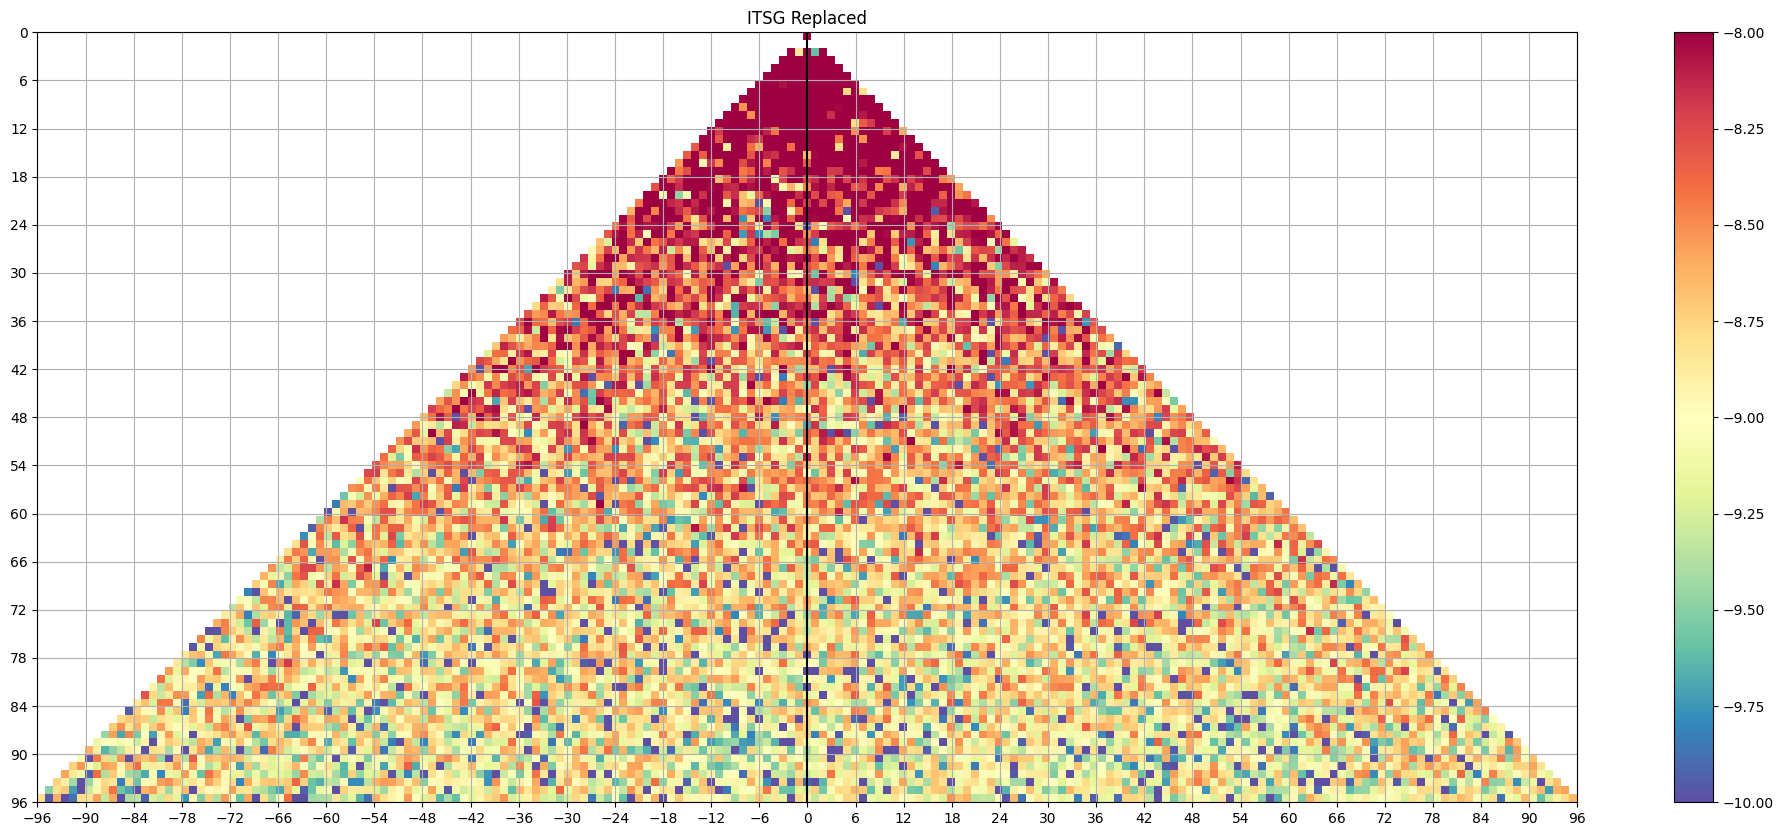

In [18]:
handle = sc_triplot(scmat=sc_mat[0], lmax=96, title="ITSG Replaced", vmin=-10, vmax=-8)

In [19]:
from pyshbundle.reshape_SH_coefficients import sc2cs

In [20]:
rep_cs = sc2cs(sc_mat[0])

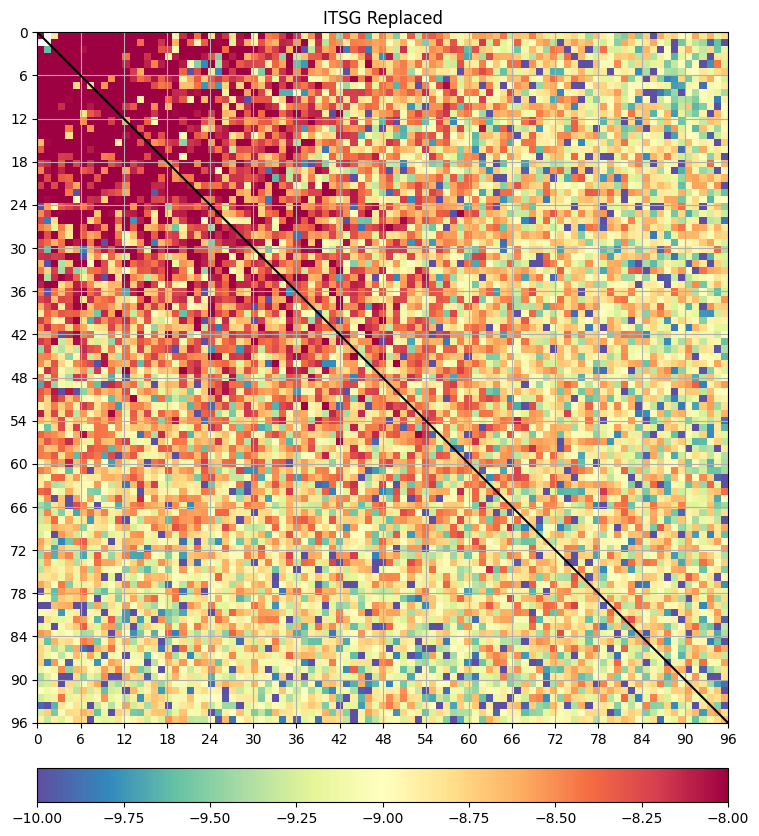

In [21]:
handle2 = cs_sqplot(csmat=rep_cs, lmax=96, title="ITSG Replaced", vmin=-10, vmax=-8)

# Long Term Gravity Field

In [22]:
# load long term mean
long_mean_itsg = '../pyshbundle/data/long_mean/SH_long_mean_itsg.npy'
SH_long_mean_itsg = np.load(long_mean_itsg)


normal_cs = normalklm(lmax=96, typ='wgs84')

# convert the format 
normal_sc = cs2sc(normal_cs)


In [23]:
# 
W = Gaussian(L=96, cap=500)

In [24]:
#basic computation
lngtrm_grav_field = gshs_prepare(lmax=96, gs=0.20, quant='gravity', grd='cell', h=0, jflag=0, sc_coeff=SH_long_mean_itsg)

(<Figure size 1600x750 with 2 Axes>,
 <GeoAxes: title={'center': 'Long Term Field'}, xlabel='Longitude', ylabel='Latitude'>)

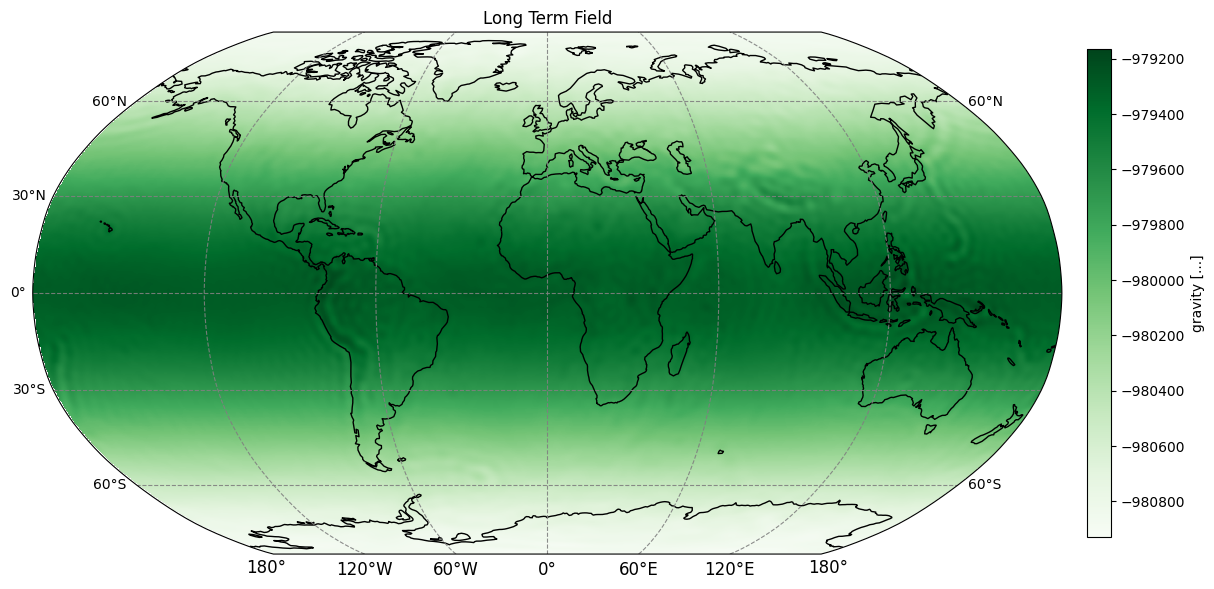

In [25]:
# Visualization for long term gravity field
mapfield(field=lngtrm_grav_field, img_extent=(-180, 180, -90, 90), title="Long Term Field", colorbar_bounds=None,)

# Normal Gravity Field 

In [26]:
#basic computation
normal_field = gshs_prepare(lmax=96, gs=0.20, quant='gravity', grd='cell', h=0, jflag=0, sc_coeff=normal_sc)

(<Figure size 1600x750 with 2 Axes>,
 <GeoAxes: title={'center': 'Normal Gravity Field - WGS84 Ellipsoid'}, xlabel='Longitude', ylabel='Latitude'>)

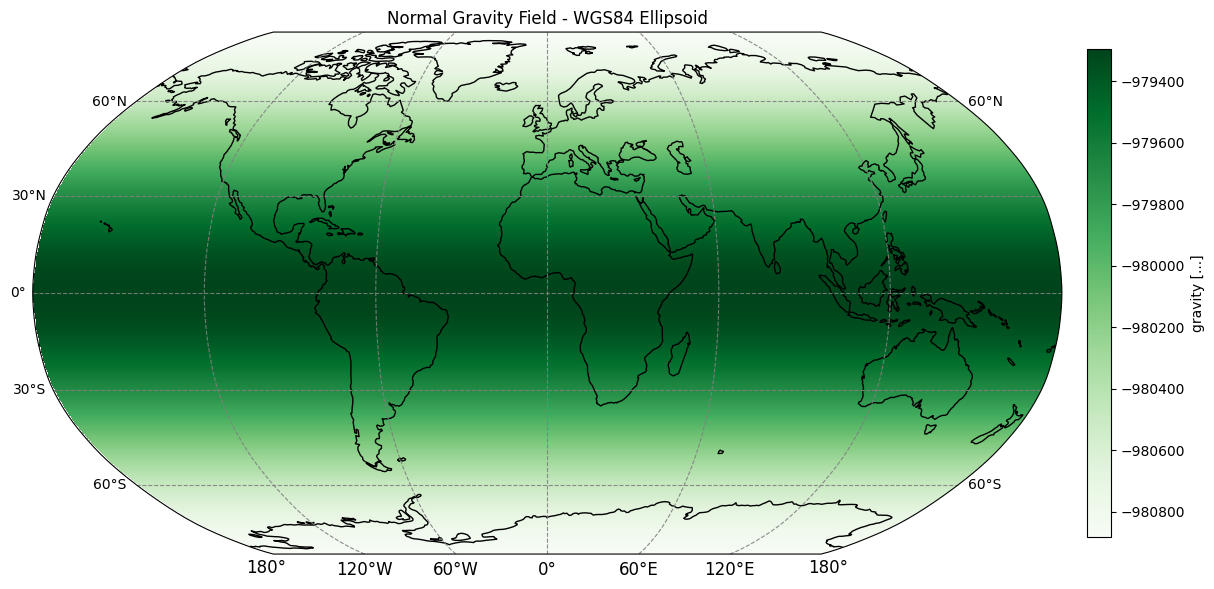

In [27]:
mapfield(field=normal_field, img_extent=(-180, 180, -90, 90), title="Normal Gravity Field - WGS84 Ellipsoid", colorbar_bounds=None)

# Temporal Gravity Field

In [28]:
temp_grav_field  = gshs_prepare(lmax=96, gs=0.20, quant='gravity', grd='cell', h=0, jflag=0, sc_coeff=sc_mat[0])

(<Figure size 1600x750 with 2 Axes>,
 <GeoAxes: title={'center': 'Temporal Gravity Field'}, xlabel='Longitude', ylabel='Latitude'>)

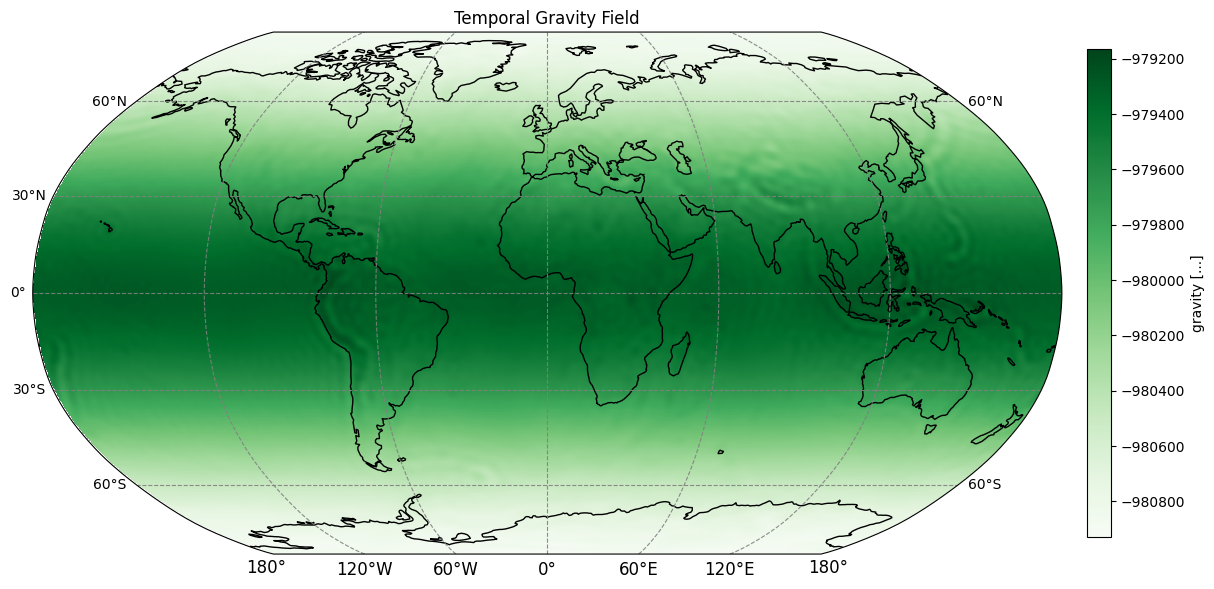

In [29]:
mapfield(field=temp_grav_field, img_extent=(-180, 180, -90, 90), title="Temporal Gravity Field", colorbar_bounds=None)

# Gravity Anomalies

In [32]:
# compute the gravity anomalies and compute the field
anom_sc = sc_mat[0]-SH_long_mean_itsg
grav_anom_field = gshs_prepare(lmax=96, gs=1, quant='gravity', grd='cell', h=0, jflag=0, sc_coeff=anom_sc)

(<Figure size 1600x750 with 2 Axes>,
 <GeoAxes: title={'center': 'Gravity Anomalies with Vertical Stripe Noise'}, xlabel='Longitude', ylabel='Latitude'>)

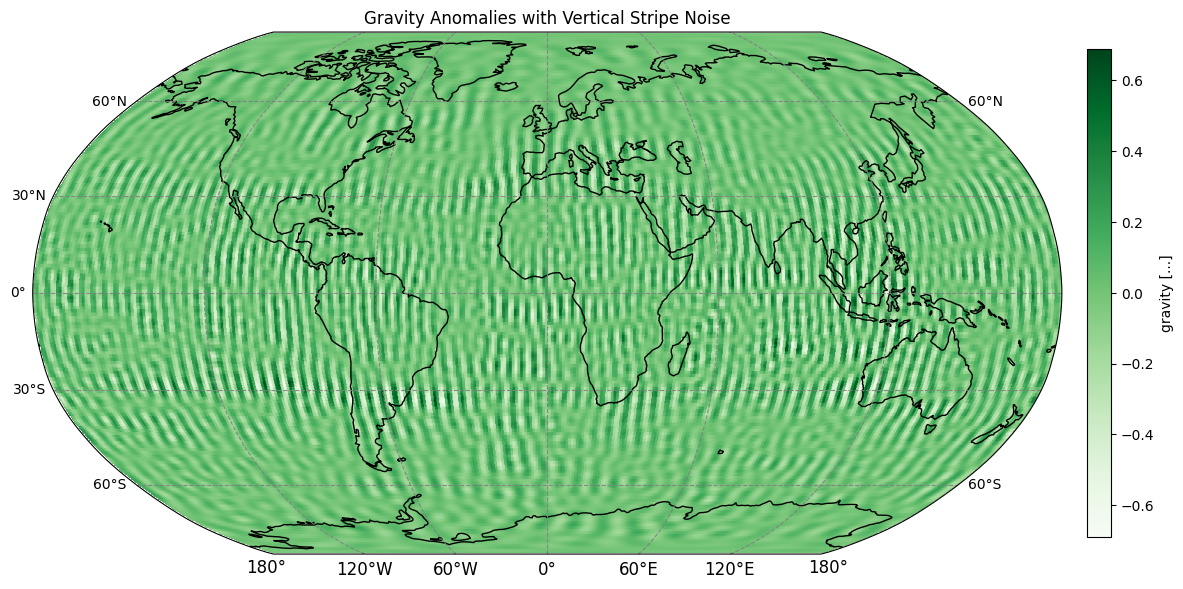

In [33]:
mapfield(field=grav_anom_field, img_extent=(-180, 180, -90, 90), title="Gravity Anomalies with Vertical Stripe Noise", colorbar_bounds=None)

* Thank you for reading this notebook. I hope you found it helpful. If you have any questions, please feel free to ask me via Github Issues